In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from string import digits
from nltk.tokenize import RegexpTokenizer
from tensorflow.keras.utils import plot_model
from keras.layers import Embedding, SpatialDropout1D, LSTM, BatchNormalization, Dropout, Dense
from keras.models import Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing.text import Tokenizer
import tensorflow as tf
from nltk.corpus import stopwords
import string
import nltk
nltk.download('words')
nltk.download('stopwords')

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

# Mount Drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
token = RegexpTokenizer("[\w']+")
sw = stopwords.words('english')
words = set(nltk.corpus.words.words())

# Get data sets and preprocessing fuctions

In [14]:
def get_datasets():
    columnLabels = ['country', 'id', 'title', 'c1', 'c2', 'c3', 'description', 'price', 'type']
    train = pd.read_csv("/content/drive/My Drive/product title classification/data_train.csv", names=columnLabels,encoding = 'utf-16 le')
    test = pd.read_csv("/content/drive/My Drive/product title classification/data_test.csv", names=columnLabels, encoding ='utf-8')
    return train, test

def preprocess_df(dataframe):
    df = pd.DataFrame()
    #tokenize and convert to lower case
    dataframe['title'] = dataframe['title'].apply(lambda x: token.tokenize(x.lower()))
    #stopword removal
    dataframe['title'] = dataframe['title'].apply(lambda x: ' '.join([w for w in x if w not in sw]))
    #remove punctuations and other symbols
    dataframe['title'] = dataframe['title'].apply(lambda x: [w for w in nltk.wordpunct_tokenize(x)\
                                                             if w is not w.isalpha() and not w.isnumeric()])
    #remove digits
    dataframe['title'] = dataframe['title'].apply(lambda x: [w.translate({ord(k): None for k in digits}) for w in x])
    #remove single length words
    dataframe['title'] = dataframe['title'].apply(lambda x: ' '.join([w for w in x if len(w)>1]))

    df['title'] = dataframe['title'].values

    df['c1'] = dataframe['c1'].values
    df['c2'] = dataframe['c2'].values
    df['c3'] = dataframe['c3'].values
    df['c3'] = df['c3'].replace(np.nan, 'none', regex=True)

    return df


Axes(0.125,0.11;0.775x0.77)


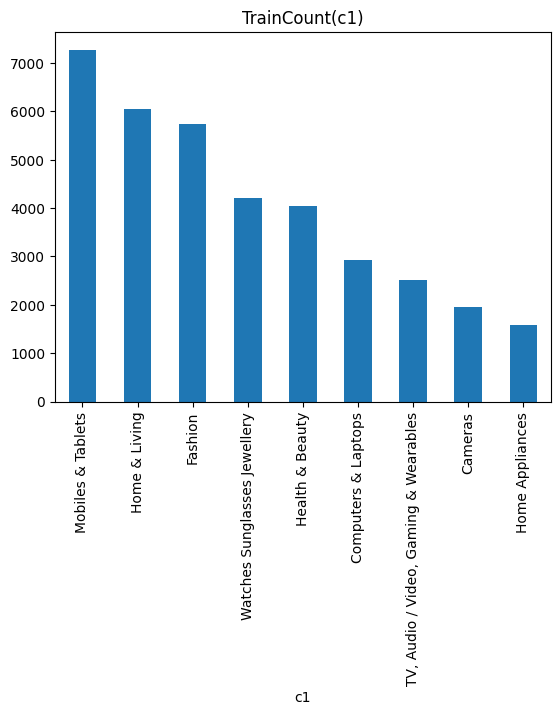

In [15]:
train_df, test_df = get_datasets()
tCol_df = preprocess_df(train_df)
tCol_df_test = preprocess_df(test_df)
print(train_df.c1.value_counts().plot(kind = 'bar', title = 'TrainCount(c1)'))

# Create padded input sequences

In [17]:
maxWords = 20000
MaxWordLength = 50
tokenizer = Tokenizer(num_words = maxWords, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(tCol_df['title'].values)

### Train input data sequences

In [18]:
train_X_c1 = tokenizer.texts_to_sequences((tCol_df['title']).values )
train_X_c1 = tf.keras.preprocessing.sequence.pad_sequences(train_X_c1, maxlen=MaxWordLength)

print('Shape of data tensor:', train_X_c1.shape)


train_X_c2 = tokenizer.texts_to_sequences((tCol_df['title']+' '+tCol_df['c1']).values )
train_X_c2 = tf.keras.preprocessing.sequence.pad_sequences(train_X_c2, maxlen=MaxWordLength)

print('Shape of data tensor:', train_X_c2.shape)


train_X_c3 = tokenizer.texts_to_sequences((tCol_df['title']+' '+tCol_df['c1']+' '+tCol_df['c2']).values )
train_X_c3 = tf.keras.preprocessing.sequence.pad_sequences(train_X_c3, maxlen=MaxWordLength)

print('Shape of data tensor:', train_X_c3.shape)

Shape of data tensor: (36283, 50)
Shape of data tensor: (36283, 50)
Shape of data tensor: (36283, 50)


### Test input data sequences

In [19]:
test_X_c1 = tokenizer.texts_to_sequences((tCol_df_test['title']).values)
test_X_c1 = tf.keras.preprocessing.sequence.pad_sequences(test_X_c1, maxlen=MaxWordLength)

print('Shape of test data tensor:', test_X_c1.shape)


test_X_c2 = tokenizer.texts_to_sequences((tCol_df_test['title']+' '+tCol_df_test['c1']).values)
test_X_c2 = tf.keras.preprocessing.sequence.pad_sequences(test_X_c2, maxlen=MaxWordLength)

print('Shape of test data tensor:', test_X_c2.shape)


test_X_c3 = tokenizer.texts_to_sequences((tCol_df_test['title']+' '+tCol_df_test['c1']+' '+tCol_df_test['c2']).values)
test_X_c3 = tf.keras.preprocessing.sequence.pad_sequences(test_X_c3, maxlen=MaxWordLength)

print('Shape of test data tensor:', test_X_c3.shape)


Shape of test data tensor: (11838, 50)
Shape of test data tensor: (11838, 50)
Shape of test data tensor: (11838, 50)


# Y-label Encoding

## Train label encoding

In [20]:
train_Y_c1 = pd.get_dummies(tCol_df['c1']).values # one hot encoding
print('Shape of label tensor:', train_Y_c1.shape)

train_Y_c2 = pd.get_dummies(tCol_df['c2']).values # one hot encoding
print('Shape of label tensor:', train_Y_c2.shape)

train_Y_c3 = pd.get_dummies(tCol_df['c3']).values # one hot encoding
print('Shape of label tensor:', train_Y_c3.shape)



Shape of label tensor: (36283, 9)
Shape of label tensor: (36283, 57)
Shape of label tensor: (36283, 185)


## Test label encoding

In [23]:
test_Y_c1 = pd.get_dummies(tCol_df_test['c1']).values
print('Shape of test label tensor:', test_Y_c1.shape)

test_Y_c2 = pd.get_dummies(tCol_df_test['c2']).values
print('Shape of test label tensor:', test_Y_c2.shape)

test_Y_c3 = pd.get_dummies(tCol_df_test['c3']).values
print('Shape of test label tensor:', test_Y_c3.shape)

Shape of test label tensor: (11838, 9)
Shape of test label tensor: (11838, 57)
Shape of test label tensor: (11838, 185)


In [24]:
#print label decoding sequence

labels_c1=sorted(tCol_df['c1'].unique())
print(labels_c1)

labels_c2=sorted(tCol_df['c2'].unique())
print(labels_c2)

labels_c3=sorted(tCol_df['c3'].unique())
print(labels_c3)


['Cameras', 'Computers & Laptops', 'Fashion', 'Health & Beauty', 'Home & Living', 'Home Appliances', 'Mobiles & Tablets', 'TV, Audio / Video, Gaming & Wearables', 'Watches Sunglasses Jewellery']
['Accessories', 'Audio', 'Bath', 'Bath & Body', 'Beauty Tools', 'Bedding', 'Boys', 'Camera Accessories', 'Computer Accessories', 'Computer Components', 'Cooling & Heating', 'DSLR', 'Desktops Computers', 'Drones', 'Eyewear', 'Food Supplements', 'Fragrances', 'Furniture', 'Gadgets', 'Gadgets & Other Cameras', 'Gaming', 'Garment Care', 'Girls', 'Hair Care', 'Home DÃ©cor', 'Home Improvement', 'Housekeeping', 'Jewellery', 'Kitchen & Dining', 'Laptops', 'Large Appliances', 'Lenses', 'Lighting', 'Makeup', 'Medical Supplies', 'Men', "Men's Care", 'Mirrorless', 'Mobiles', 'Network Components', 'Outdoor & Garden', 'Personal Care', 'Point & Shoot', 'Printers & Accessories', 'Skin Care', 'Small Kitchen Appliances', 'Stationery', 'Storage', 'Storage & Organisation', 'TV Accessories', 'Tablets', 'Televisions

# Create NN Architecture and Train Model - Category1

In [37]:
import os
from tensorflow.keras.models import load_model
# Define model for category 1
c1_count = train_df['c1'].nunique()
embeddingDimensions = 100
def create_model():
    model = Sequential()
    model.add(Embedding(maxWords, embeddingDimensions, input_length=train_X_c1.shape[1]))
    model.add(LSTM(512, dropout=0.4, recurrent_dropout=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(c1_count, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model
checkpoint_path = '/content/drive/My Drive/product_title_classification/h_Models/model_c1_best.h5'
final_model_path = '/content/drive/My Drive/product_title_classification/h_Models/model_c1_final.h5'
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, min_delta=0.0001)
model_checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True, save_weights_only=False)
if os.path.exists(final_model_path):
    model_c1 = load_model(final_model_path)
    print("Loaded model from disk.")
else:
    model_c1 = create_model()
    print("Created a new model.")
model_c1.summary()
epochs = 5
batch_size = 64
history1 = model_c1.fit(train_X_c1, train_Y_c1,
                        validation_data=(test_X_c1, test_Y_c1),
                        epochs=epochs, batch_size=batch_size,
                        shuffle=True,
                        callbacks=[early_stopping, model_checkpoint]
                        )

# Save the final model to Google Drive
model_c1.save(final_model_path)

# Verify saving and loading
loaded_model = tf.keras.models.load_model(final_model_path)
loaded_model.summary()

Loaded model from disk.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 100)           2000000   
                                                                 
 lstm (LSTM)                 (None, 512)               1255424   
                                                                 
 dense (Dense)               (None, 128)               65664     
                                                                 
 dense_1 (Dense)             (None, 9)                 1161      
                                                                 
Total params: 3322249 (12.67 MB)
Trainable params: 3322249 (12.67 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/5
567/567 [==============================] - ETA: 0s - loss: 0.0660 - accuracy: 0.9789

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


567/567 [==============================] - 116s 199ms/step - loss: 0.0660 - accuracy: 0.9789 - val_loss: 0.3464 - val_accuracy: 0.9214
Epoch 2/5
567/567 [==============================] - 104s 183ms/step - loss: 0.0549 - accuracy: 0.9816 - val_loss: 0.3667 - val_accuracy: 0.9137
Epoch 3/5
567/567 [==============================] - 114s 200ms/step - loss: 0.0503 - accuracy: 0.9826 - val_loss: 0.4005 - val_accuracy: 0.9156
Epoch 4/5
567/567 [==============================] - 119s 210ms/step - loss: 0.0442 - accuracy: 0.9852 - val_loss: 0.4100 - val_accuracy: 0.9162


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 100)           2000000   
                                                                 
 lstm (LSTM)                 (None, 512)               1255424   
                                                                 
 dense (Dense)               (None, 128)               65664     
                                                                 
 dense_1 (Dense)             (None, 9)                 1161      
                                                                 
Total params: 3322249 (12.67 MB)
Trainable params: 3322249 (12.67 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# Create NN Architecture and Train Model - Category2

In [38]:
# Define model for category 2
c2_count = train_df['c2'].nunique()
embeddingDimensions = 100

def create_model():
    model = Sequential()
    model.add(Embedding(maxWords, embeddingDimensions, input_length=train_X_c2.shape[1]))
    model.add(LSTM(512, dropout=0.4, recurrent_dropout=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(c2_count, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Checkpoint paths
checkpoint_path = '/content/drive/My Drive/product_title_classification/h_Models/model_c2_best.h5'
final_model_path = '/content/drive/My Drive/product_title_classification/h_Models/model_c2_final.h5'

# Define callbacks
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, min_delta=0.0001)
model_checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True, save_weights_only=False)

# Check if model already exists
if os.path.exists(final_model_path):
    # Load the existing model
    model_c2 = load_model(final_model_path)
    print("Loaded model from disk.")
else:
    # Create a new model
    model_c2 = create_model()
    print("Created a new model.")

# Print model summary
model_c2.summary()

# Train the model
epochs = 5
batch_size = 64

history2 = model_c2.fit(train_X_c2, train_Y_c2,
                        validation_data=(test_X_c2, test_Y_c2),
                        epochs=epochs, batch_size=batch_size,
                        shuffle=True,
                        callbacks=[early_stopping, model_checkpoint]
                        )

# Save the final model to Google Drive
model_c2.save(final_model_path)

# Verify saving and loading
loaded_model = tf.keras.models.load_model(final_model_path)
loaded_model.summary()




Created a new model.
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 50, 100)           2000000   
                                                                 
 lstm_2 (LSTM)               (None, 512)               1255424   
                                                                 
 dense_4 (Dense)             (None, 128)               65664     
                                                                 
 dense_5 (Dense)             (None, 57)                7353      
                                                                 
Total params: 3328441 (12.70 MB)
Trainable params: 3328441 (12.70 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/5
567/567 [==============================] - 152s 261ms/step - loss: 1.2544 - accuracy: 0.6419 - val_loss: 0.6026 - v

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


567/567 [==============================] - 107s 189ms/step - loss: 0.4412 - accuracy: 0.8608 - val_loss: 0.4508 - val_accuracy: 0.8612
Epoch 3/5
567/567 [==============================] - 102s 180ms/step - loss: 0.2855 - accuracy: 0.9126 - val_loss: 0.4527 - val_accuracy: 0.8681
Epoch 4/5
567/567 [==============================] - 102s 180ms/step - loss: 0.2121 - accuracy: 0.9372 - val_loss: 0.4571 - val_accuracy: 0.8685
Epoch 5/5
567/567 [==============================] - 101s 178ms/step - loss: 0.1654 - accuracy: 0.9494 - val_loss: 0.4552 - val_accuracy: 0.8784


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 50, 100)           2000000   
                                                                 
 lstm_2 (LSTM)               (None, 512)               1255424   
                                                                 
 dense_4 (Dense)             (None, 128)               65664     
                                                                 
 dense_5 (Dense)             (None, 57)                7353      
                                                                 
Total params: 3328441 (12.70 MB)
Trainable params: 3328441 (12.70 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [53]:
print(train_df['c3'].nunique())

184


# Create NN Architecture and Train Model - Category3

In [54]:
# Define model for category 3
c3_count = tCol_df['c3'].nunique()
embeddingDimensions = 100

def create_model():
    model = Sequential()
    model.add(Embedding(maxWords, embeddingDimensions, input_length=train_X_c3.shape[1]))
    model.add(LSTM(512, dropout=0.4, recurrent_dropout=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(c3_count, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Checkpoint paths
checkpoint_path = '/content/drive/My Drive/product_title_classification/h_Models/model_c3_best.h5'
final_model_path = '/content/drive/My Drive/product_title_classification/h_Models/model_c3_final.h5'

# Define callbacks
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, min_delta=0.0001)
model_checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True, save_weights_only=False)

# Check if model already exists
if os.path.exists(final_model_path):
    # Load the existing model
    model_c3 = load_model(final_model_path)
    print("Loaded model from disk.")
else:
    # Create a new model
    model_c3 = create_model()
    print("Created a new model.")

# Print model summary
model_c3.summary()

# Train the model
epochs = 5
batch_size = 64

history3 = model_c3.fit(train_X_c3, train_Y_c3,
                        validation_data=(test_X_c3, test_Y_c3),
                        epochs=epochs, batch_size=batch_size,
                        shuffle=True,
                        callbacks=[early_stopping, model_checkpoint]
                        )

# Save the final model to Google Drive
model_c3.save(final_model_path)

# Verify saving and loading
loaded_model = tf.keras.models.load_model(final_model_path)
loaded_model.summary()




Created a new model.
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 50, 100)           2000000   
                                                                 
 lstm_5 (LSTM)               (None, 512)               1255424   
                                                                 
 dense_10 (Dense)            (None, 128)               65664     
                                                                 
 dense_11 (Dense)            (None, 185)               23865     
                                                                 
Total params: 3344953 (12.76 MB)
Trainable params: 3344953 (12.76 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/5
567/567 [==============================] - 117s 199ms/step - loss: 2.3396 - accuracy: 0.4157 - val_loss: 1.1014 - v

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


567/567 [==============================] - 125s 220ms/step - loss: 0.8976 - accuracy: 0.6725 - val_loss: 0.7795 - val_accuracy: 0.7173
Epoch 3/5
567/567 [==============================] - 118s 208ms/step - loss: 0.6479 - accuracy: 0.7636 - val_loss: 0.6894 - val_accuracy: 0.7539
Epoch 4/5
567/567 [==============================] - 104s 184ms/step - loss: 0.5032 - accuracy: 0.8212 - val_loss: 0.6880 - val_accuracy: 0.7728
Epoch 5/5
567/567 [==============================] - 102s 180ms/step - loss: 0.4075 - accuracy: 0.8563 - val_loss: 0.7001 - val_accuracy: 0.7756


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 50, 100)           2000000   
                                                                 
 lstm_5 (LSTM)               (None, 512)               1255424   
                                                                 
 dense_10 (Dense)            (None, 128)               65664     
                                                                 
 dense_11 (Dense)            (None, 185)               23865     
                                                                 
Total params: 3344953 (12.76 MB)
Trainable params: 3344953 (12.76 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


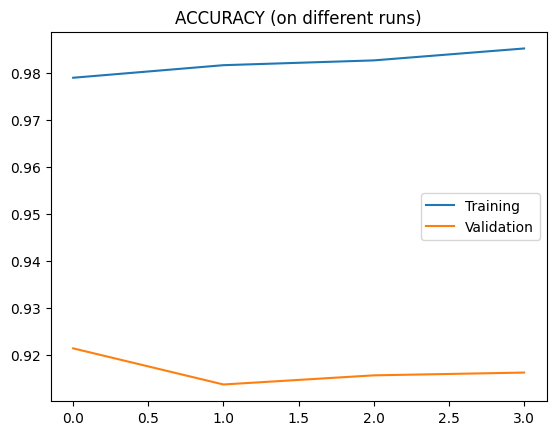

In [55]:
accs=history1.history['accuracy']
val_accs=history1.history['val_accuracy']
plt.title('ACCURACY (on different runs)')
plt.plot(range(len(accs)), accs, label='Training')
plt.plot(range(len(accs)), val_accs, label='Validation')
plt.legend()
plt.show()

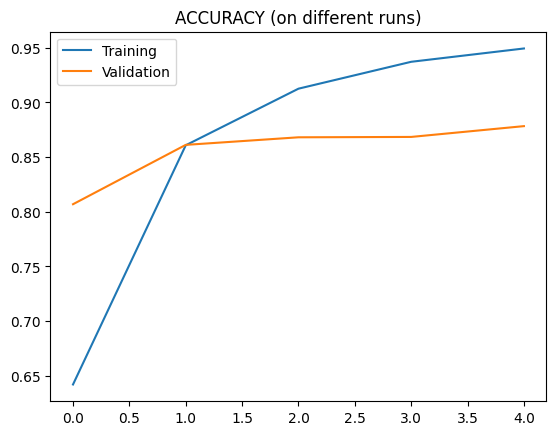

In [56]:
accs=history2.history['accuracy']
val_accs=history2.history['val_accuracy']
plt.title('ACCURACY (on different runs)')
plt.plot(range(len(accs)), accs, label='Training')
plt.plot(range(len(accs)), val_accs, label='Validation')
plt.legend()
plt.show()

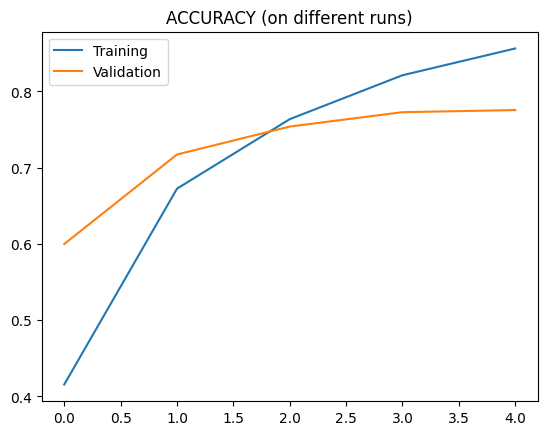

In [57]:
accs=history3.history['accuracy']
val_accs=history3.history['val_accuracy']
plt.title('ACCURACY (on different runs)')
plt.plot(range(len(accs)), accs, label='Training')
plt.plot(range(len(accs)), val_accs, label='Validation')
plt.legend()
plt.show()

# Load Model

In [62]:
model_c1=tf.keras.models.load_model('/content/drive/My Drive/product_title_classification/h_Models/model_c1_final.h5')

In [63]:
model_c2=tf.keras.models.load_model('/content/drive/My Drive/product_title_classification/h_Models/model_c2_final.h5')

In [64]:
model_c3=tf.keras.models.load_model('/content/drive/My Drive/product_title_classification/h_Models/model_c3_final.h5')

# Prediction on test set

# Title Prediction on real time example

In [78]:
new_x=[]

x = str(input("Enter the product title : "))

# title preprocessing
new_x.append(x)
seq = tokenizer.texts_to_sequences(new_x)
padded = tf.keras.preprocessing.sequence.pad_sequences(seq, maxlen=MaxWordLength)

# c1 prediction
pred1 = model_c1.predict(padded)
print('Category 1: ',labels_c1[np.argmax(pred1)])

# concatenate title + c1
new_x[0]=new_x[0]+' '+labels_c1[np.argmax(pred1)]

# title + c1 preprocessing
seq = tokenizer.texts_to_sequences(new_x)
padded = tf.keras.preprocessing.sequence.pad_sequences(seq, maxlen=MaxWordLength)

# c2 prediction
pred2 = model_c2.predict(padded)
print('Category 2: ',labels_c2[np.argmax(pred2)])

# concatenate title + c1 + c2
new_x[0]=new_x[0]+' '+labels_c2[np.argmax(pred2)]

# title + c1 + c2 preprocessing
seq = tokenizer.texts_to_sequences(new_x)
padded = tf.keras.preprocessing.sequence.pad_sequences(seq, maxlen=MaxWordLength)

# c3 prediction
pred3 = model_c3.predict(padded)
print('Category 3: ',labels_c3[np.argmax(pred3)])


# pred[0][np.argmax(pred)

Enter the product title : pendant
1/1 [==============================] - 0s 304ms/step
Category 1:  Watches Sunglasses Jewellery
1/1 [==============================] - 0s 228ms/step
Category 2:  Jewellery
1/1 [==============================] - 0s 229ms/step
Category 3:  Women


# Model Evaluation

In [68]:
acc = model_c1.evaluate(test_X_c1, test_Y_c1)
ModelAccuracy1 = acc[1]
print('ModelAccuracy for c1 =',round(acc[1],2)*100,'%')
model_c1.summary()

370/370 [==============================] - 6s 16ms/step - loss: 0.4100 - accuracy: 0.9162
ModelAccuracy for c1 = 92.0 %
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 100)           2000000   
                                                                 
 lstm (LSTM)                 (None, 512)               1255424   
                                                                 
 dense (Dense)               (None, 128)               65664     
                                                                 
 dense_1 (Dense)             (None, 9)                 1161      
                                                                 
Total params: 3322249 (12.67 MB)
Trainable params: 3322249 (12.67 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [70]:
acc = model_c2.evaluate(test_X_c2, test_Y_c2)
ModelAccuracy2 = acc[1]
print('ModelAccuracy for c2 =',round(acc[1],2)*100,'%')
model_c2.summary()

370/370 [==============================] - 8s 20ms/step - loss: 0.4552 - accuracy: 0.8784
ModelAccuracy for c2 = 88.0 %
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 50, 100)           2000000   
                                                                 
 lstm_2 (LSTM)               (None, 512)               1255424   
                                                                 
 dense_4 (Dense)             (None, 128)               65664     
                                                                 
 dense_5 (Dense)             (None, 57)                7353      
                                                                 
Total params: 3328441 (12.70 MB)
Trainable params: 3328441 (12.70 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [71]:
acc = model_c3.evaluate(test_X_c3, test_Y_c3)
ModelAccuracy3 = acc[1]
print('ModelAccuracy for c3 =',round(acc[1],2)*100,'%')
model_c3.summary()

370/370 [==============================] - 8s 20ms/step - loss: 0.7001 - accuracy: 0.7756
ModelAccuracy for c3 = 78.0 %
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 50, 100)           2000000   
                                                                 
 lstm_5 (LSTM)               (None, 512)               1255424   
                                                                 
 dense_10 (Dense)            (None, 128)               65664     
                                                                 
 dense_11 (Dense)            (None, 185)               23865     
                                                                 
Total params: 3344953 (12.76 MB)
Trainable params: 3344953 (12.76 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Overall Accuracy

In [66]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

In [72]:
Overall_accuracy = ((ModelAccuracy1+ModelAccuracy2+ModelAccuracy3)/3)*100
print("Overall Model accuracy is: ", round(Overall_accuracy,3),'%')

Overall Model accuracy is:  85.67 %
